In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random

# Dataset Loading

Dataset didapatkan dari - https://github.com/kirralabs/Indonesian-Word-Tagged & ditambahkan beberapa kata baru

In [272]:
word_slang = pd.read_csv('word-slang.txt', header=None)

In [273]:
word_slang.head()

,0,1
0,absen,absen
1,absn,absen
2,lusa,lusa
3,usa,lusa
4,stu,satu


# Dataset Creation

In [274]:
random.seed(13517013)

data = []

max_typo_len = 0
max_real_word_len = 0

typo_char = set()
real_word_char = set()

max_edit = 1
max_len = 12
min_len = 3

real_word_char.add('\t')
real_word_char.add('\n')

In [275]:
for index in range(len(word_slang)):
  slang = word_slang.iloc[index, 0].lower()
  arti = word_slang.iloc[index, 1].lower()

  if(len(slang) <= max_len and len(arti) <= max_len):
    max_typo_len = max(len(slang), max_typo_len)
    max_real_word_len = max(len(arti)+2, max_real_word_len)

    for char in slang:
      if char not in typo_char:
        typo_char.add(char)
    for char in arti:
      if char not in real_word_char:
        real_word_char.add(char)
    
    data.append((slang, '\t' + arti + '\n'))

In [276]:
typo_char = sorted(list(typo_char))
real_word_char = sorted(list(real_word_char))

typo_char_map = dict((c, i) for i, c in enumerate(typo_char))
real_word_char_map = dict((c, i) for i, c in enumerate(real_word_char))

num_encoder_tokens = len(typo_char)
num_decoder_tokens = len(real_word_char)

encoder_seq_lengths = max_typo_len
decoder_seq_lengths = max_real_word_len

In [277]:
print('num_encoder_tokens: ', num_encoder_tokens)
print('num_decoder_tokens: ', num_decoder_tokens)
print('encoder_seq_lengths: ', encoder_seq_lengths)
print('decoder_seq_lengths: ', decoder_seq_lengths)

num_encoder_tokens:  40
num_decoder_tokens:  38
encoder_seq_lengths:  12
decoder_seq_lengths:  14


In [278]:
typo_char_map

{' ': 0,
 '-': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 '@': 13,
 'a': 14,
 'b': 15,
 'c': 16,
 'd': 17,
 'e': 18,
 'f': 19,
 'g': 20,
 'h': 21,
 'i': 22,
 'j': 23,
 'k': 24,
 'l': 25,
 'm': 26,
 'n': 27,
 'o': 28,
 'p': 29,
 'q': 30,
 'r': 31,
 's': 32,
 't': 33,
 'u': 34,
 'v': 35,
 'w': 36,
 'x': 37,
 'y': 38,
 'z': 39}

In [279]:
real_word_char_map

{'\t': 0,
 '\n': 1,
 ' ': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '8': 10,
 '9': 11,
 'a': 12,
 'b': 13,
 'c': 14,
 'd': 15,
 'e': 16,
 'f': 17,
 'g': 18,
 'h': 19,
 'i': 20,
 'j': 21,
 'k': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'q': 28,
 'r': 29,
 's': 30,
 't': 31,
 'u': 32,
 'v': 33,
 'w': 34,
 'x': 35,
 'y': 36,
 'z': 37}

In [280]:
df = pd.DataFrame(data, columns=['Typo', 'RealWord']).drop_duplicates(['Typo'], keep='first')

In [281]:
print(df[:20])

        Typo      RealWord
0      absen     \tabsen\n
1       absn     \tabsen\n
2       lusa      \tlusa\n
3        usa      \tlusa\n
4        stu      \tsatu\n
5        dua       \tdua\n
6       tiga      \ttiga\n
7        tga      \ttiga\n
8      empat     \tempat\n
9       empt     \tempat\n
10      lima      \tlima\n
11       ima      \tlima\n
12      enam      \tenam\n
13       nam      \tenam\n
14     tujuh     \ttujuh\n
15       tjh     \ttujuh\n
16   delapan   \tdelapan\n
17      dlpn   \tdelapan\n
18  sembilan  \tsembilan\n
19     smbln  \tsembilan\n


In [282]:
df.describe()

,Typo,RealWord
count,13339,13339
unique,13339,6783
top,asesoris,\tbanget\n
freq,1,91


In [283]:
encoder_input_data = np.zeros((len(df), encoder_seq_lengths, num_encoder_tokens), dtype="float32")
decoder_input_data = np.zeros((len(df), decoder_seq_lengths, num_decoder_tokens), dtype="float32")
decoder_target_data = np.zeros((len(df), decoder_seq_lengths, num_decoder_tokens), dtype="float32")

In [284]:
for index in range(len(df)):
  if(index % 5000 == 0):
    print(index)
  for i, char in enumerate(df.iloc[index, 0]):
    encoder_input_data[index, i, typo_char_map[char]] = 1.0
  # Anggap sisa dari row['Typo'] adalah spasi
  encoder_input_data[index, i+1:, typo_char_map[' ']] = 1.0
  
  for i, char in enumerate(df.iloc[index, 1]):
    decoder_input_data[index, i, real_word_char_map[char]] = 1.0
    if(i > 0):
      decoder_target_data[index, i-1, real_word_char_map[char]] = 1.0
  # Anggap sisa dari row['RealWord'] adalah spasi
  decoder_input_data[index, i+1:, real_word_char_map[' ']] = 1.0
  decoder_target_data[index, i:, real_word_char_map[' ']] = 1.0

0
5000
10000



# Training

In [285]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout

In [300]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm_1 = LSTM(100, return_sequences=True)
encoder_dropout_1 = Dropout(0.4)
encoder_lstm_2 = LSTM(100, return_state=True)

encoder_outputs, state_h, state_c = encoder_lstm_2(encoder_dropout_1(encoder_lstm_1(encoder_inputs)))

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(100, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [301]:
model.summary()

Model: "functional_102"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, None, 40)]   0                                            
__________________________________________________________________________________________________
lstm_27 (LSTM)                  (None, None, 100)    56400       input_23[0][0]                   
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, None, 100)    0           lstm_27[0][0]                    
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, None, 38)]   0                                            
_____________________________________________________________________________________

In [302]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [303]:
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=32,
    epochs=100,
)

Epoch 1/100
417/417 [==============================] - 4s 9ms/step - loss: 1.5102 - accuracy: 0.5786
Epoch 2/100
417/417 [==============================] - 4s 9ms/step - loss: 1.0081 - accuracy: 0.6996
Epoch 3/100
417/417 [==============================] - 4s 9ms/step - loss: 0.8441 - accuracy: 0.7494
Epoch 4/100
417/417 [==============================] - 4s 9ms/step - loss: 0.7580 - accuracy: 0.7780
Epoch 5/100
417/417 [==============================] - 4s 9ms/step - loss: 0.7013 - accuracy: 0.7959
Epoch 6/100
417/417 [==============================] - 4s 9ms/step - loss: 0.6604 - accuracy: 0.8088
Epoch 7/100
417/417 [==============================] - 4s 9ms/step - loss: 0.6270 - accuracy: 0.8188
Epoch 8/100
417/417 [==============================] - 4s 9ms/step - loss: 0.5985 - accuracy: 0.8274
Epoch 9/100
417/417 [==============================] - 4s 9ms/step - loss: 0.5717 - accuracy: 0.8355
Epoch 10/100
417/417 [==============================] - 4s 9ms/step - loss: 0.5510 - accura

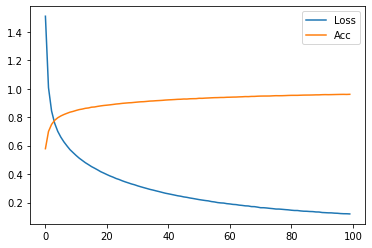

In [304]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.legend(['Loss', 'Acc'])
plt.show()

In [313]:
model.save('typo-correction')

INFO:tensorflow:Assets written to: typo-correction/assets


In [315]:
!zip -r typo-correction-ver1.zip typo-correction/

  adding: typo-correction/ (stored 0%)
  adding: typo-correction/saved_model.pb (deflated 90%)
  adding: typo-correction/variables/ (stored 0%)
  adding: typo-correction/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: typo-correction/variables/variables.index (deflated 65%)
  adding: typo-correction/assets/ (stored 0%)


In [305]:
class SpellCheckModule:
  def __init__(self, model, typo_char_map, real_word_char_map, num_encoder_tokens, num_decoder_tokens, encoder_seq_lengths, decoder_seq_lengths):
    encoder_inputs = model.input[0]  # input_1
    encoder_lstm_1 = model.layers[1] # lstm_encoder_1
    encoder_dropout = model.layers[2]
    encoder_lstm_2 = model.layers[4] # lstm_encoder_2

    encoder_lstm_1_out = encoder_dropout(encoder_lstm_1(encoder_inputs))
    encoder_lstm_2_out, state_h_enc, state_c_enc = encoder_lstm_2(encoder_lstm_1_out)
    encoder_states = [state_h_enc, state_c_enc]
    self.encoder_model = Model(encoder_inputs, encoder_states)

    decoder_inputs = model.input[1]  # input_2
    decoder_state_input_h = Input(shape=(100,), name="input_dec_h")
    decoder_state_input_c = Input(shape=(100,), name="input_dec_c")
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm = model.layers[5]
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h_dec, state_c_dec]
    decoder_dense = model.layers[6]
    decoder_outputs = decoder_dense(decoder_outputs)
    self.decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
    )

    self.typo_char_map = typo_char_map
    self.real_word_char_map = real_word_char_map

    self.num_encoder_tokens = num_encoder_tokens
    self.encoder_seq_lengths = encoder_seq_lengths
    self.num_decoder_tokens = num_decoder_tokens
    self.decoder_seq_lengths = decoder_seq_lengths
    
    self.reverse_input_char_index = dict((i, char) for char, i in typo_char_map.items())
    self.reverse_target_char_index = dict((i, char) for char, i in real_word_char_map.items())

  def _fix_word(self, word_mat):
    states_value = self.encoder_model.predict(word_mat)

    target_seq = np.zeros((1, 1, self.num_decoder_tokens))
    target_seq[0, 0, self.real_word_char_map["\t"]] = 1.0

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
      output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)

      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_char = self.reverse_target_char_index[sampled_token_index]
      decoded_sentence += sampled_char

      if sampled_char == "\n" or len(decoded_sentence) > self.decoder_seq_lengths:
        stop_condition = True

      target_seq = np.zeros((1, 1, self.num_decoder_tokens))
      target_seq[0, 0, sampled_token_index] = 1.0

      states_value = [h, c]
    return decoded_sentence

  def fix_sentence(self, sentence):
    s = [w.lower() for w in sentence.split(' ')]
    input_seq = np.zeros((len(s), self.encoder_seq_lengths, self.num_encoder_tokens), dtype="float32")
    pred = []
    for w, word in enumerate(s):
      if (word.replace('-','').replace('/','').isdigit()):
        pred.append(word)
      else:
        unknown_char = 0
        iter = 0
        for i, char in enumerate(word):
          if (char in self.typo_char_map):
            input_seq[w, iter, self.typo_char_map[char]] = 1.0
            iter += 1
          else:
            unknown_char += 1
        input_seq[w, iter+1:, self.typo_char_map[' ']] = 1.0
        
        if (float(unknown_char)/len(word) > 0.5):
          pred.append(word)
        else:
          pred.append(self._fix_word(input_seq[w:w+1])[:-1])
    return ' '.join(pred)

In [306]:
spellChecker = SpellCheckModule(
    model,
    typo_char_map, real_word_char_map,
    num_encoder_tokens, num_decoder_tokens,
    encoder_seq_lengths, decoder_seq_lengths
)

In [307]:
spellChecker.fix_sentence('ak maw cuti bsk')

'aku mau cuti besok'

In [308]:
spellChecker.fix_sentence('absen bsk sampe lusa')

'absen besok sampai lusa'

In [309]:
spellChecker.fix_sentence('thx y gan')

'terima kasih iya gang'

In [312]:
spellChecker.fix_sentence('aku cuti 12-13 nov')

'aku cuti 12-13 november'

In [317]:
import pickle

In [325]:
pickle.dump(
    {
      'typo_char_map': typo_char_map,
      'real_word_char_map': real_word_char_map,
      'num_encoder_tokens': num_encoder_tokens,
      'num_decoder_tokens': num_decoder_tokens,
      'encoder_seq_lengths': encoder_seq_lengths,
      'decoder_seq_lengths': decoder_seq_lengths,
    }, open('data.json', 'wb')
)

# Load Saved model and data

In [329]:
from tensorflow.keras.models import load_model

In [328]:
saved_data = pickle.load(open('data.json', 'rb'))

In [330]:
saved_model = load_model('typo-correction')

In [331]:
loadedSpellChecker = SpellCheckModule(saved_model,
                                      saved_data['typo_char_map'], saved_data['real_word_char_map'],
                                      saved_data['num_encoder_tokens'], saved_data['num_decoder_tokens'],
                                      saved_data['encoder_seq_lengths'], saved_data['decoder_seq_lengths'])

In [332]:
print(spellChecker.fix_sentence('ak maw cuti bsk'))

aku mau cuti besok
